In [1]:
import torch
import torch.nn as nn
import math
from torchviz import make_dot

# Сеть с множеством выходов 

Если сеть имеет множество выходов, то backward по их сумме эквивалентен backward-у по каждому из них 

## Пример 

In [2]:
criterion = nn.MSELoss()

In [3]:
class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()
    
    def right(self,x):
        a = torch.tanh(x)
        b = torch.tan(a)
        return b.sum()
        
    def center(self,x):
        a = torch.tan(x)
        b = torch.cos(a)
        return b.mean()
    
    def left(self,x):
        a = torch.cos(x)
        b = torch.tanh(a)
        return b.sum()
        
    
    def forward(self, x):
        a = torch.sin(x)
        c = 2 * a
        loss1 = self.left(c[:8])
        loss2 = self.center(c[8:16])
        loss3 = self.right(c[16:24])
        return loss1, loss2, loss3

In [4]:
model = TinyModel()

In [5]:
def get_losses():
    torch.manual_seed(89)
    input = torch.linspace(0., 2. * math.pi, steps=24, requires_grad=True)
    loss1, loss2, loss3 = model(input)
    return input, loss1, loss2, loss3

In [6]:
def print_graph(x):
    return make_dot(x, params=dict(model.named_parameters()))

### backward по сумме ошибок

In [7]:
input, loss1, loss2, loss3 = get_losses()

In [8]:
loss = loss1 + loss2 + loss3

In [9]:
base_graph = loss.clone()

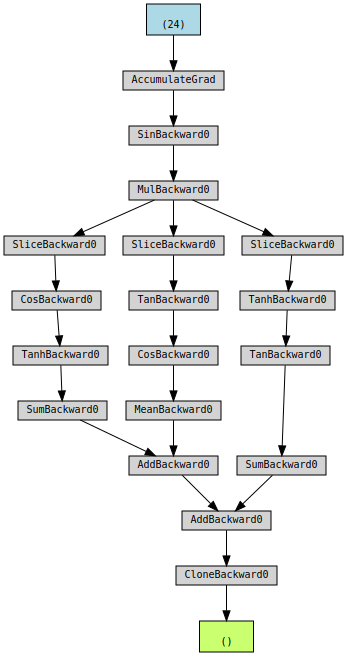

In [10]:
print_graph(base_graph)

In [11]:
loss.backward()
grad1 = input.grad.clone()
print(grad1)

tensor([ 0.0000, -0.5113, -1.1510, -1.3410, -0.8646, -0.3277,  0.1054,  0.5801,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])


### backward по каждому выходу

In [12]:
input, loss1, loss2, loss3 = get_losses()

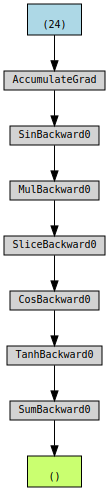

In [13]:
print_graph(loss1)

In [14]:
loss1.backward(retain_graph=True)

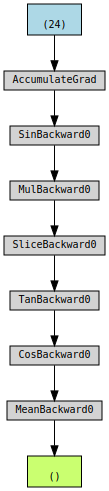

In [15]:
print_graph(loss2)

In [16]:
loss2.backward(retain_graph=True)

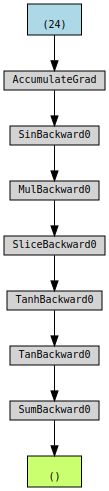

In [17]:
print_graph(loss3)

In [18]:
loss3.backward()

In [19]:
print(input.grad)

tensor([ 0.0000, -0.5113, -1.1510, -1.3410, -0.8646, -0.3277,  0.1054,  0.5801,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])


In [20]:
input.grad == grad1

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True])

Обратите внимание на параметр **retain_graph=True** в функции backward, без него вычислительный граф будет уничтожен после первого вызова функции backward. См. документацию https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html

## In-place операции 

Обратите внимание, что операции на месте меняют вычислительный граф

In [21]:
input, loss1, loss2, loss3 = get_losses()

In [22]:
loss1 += loss1 + loss2 + loss3

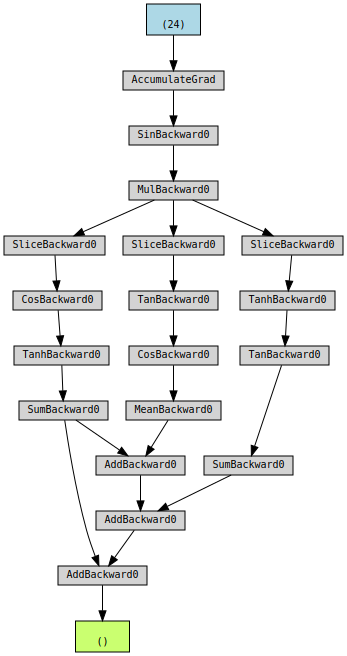

In [23]:
print_graph(loss1)

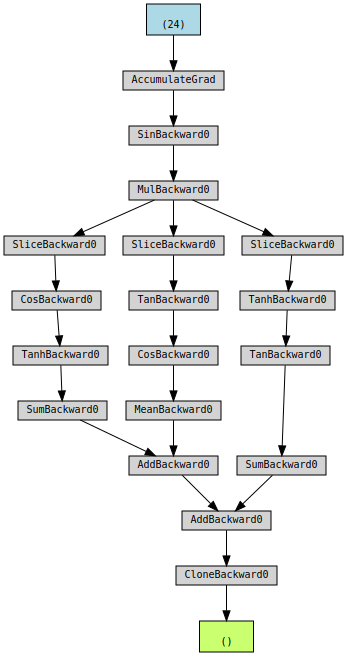

In [24]:
print_graph(base_graph)

In [25]:
loss1.backward()

In [26]:
input.grad

tensor([ 0.0000, -1.0226, -2.3020, -2.6820, -1.7291, -0.6555,  0.2109,  1.1601,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])

In [27]:
grad1

tensor([ 0.0000, -0.5113, -1.1510, -1.3410, -0.8646, -0.3277,  0.1054,  0.5801,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])

In [28]:
grad1 == input.grad

tensor([ True, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True])

Как следствие изменился и градиент. Старайтесь избегать In-place операций в вычислительных графах 